In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from prettytable import PrettyTable
from numpy import expand_dims
!pip install keras_adabound
from keras_adabound import AdaBound
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, Callback, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-cp36-none-any.whl size=6609 sha256=7535bfa91ae6f1ad1aec6ea9fb94adc33133bc89736b6268739d59d8732503b6
  Stored in directory: /root/.cache/pip/wheels/f1/81/9c/04af926d62bddd280c97af1704a9baaef511664b56865958e8
Successfully built keras-adabound


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [10]:
compression = 1
num_classes = 10

In [11]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 4s 0us/step


In [12]:
X_train.shape

(50000, 32, 32, 3)

In [13]:
X_test.shape

(10000, 32, 32, 3)

In [14]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2, nb_layers=40):
    global compression
    temp = input
    for _ in range(nb_layers):
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [101]:
#image data generator for image augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.3,
    featurewise_center=True, 
    featurewise_std_normalization=True,
    fill_mode='nearest'
)

val_datagen =ImageDataGenerator(featurewise_std_normalization=True,)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


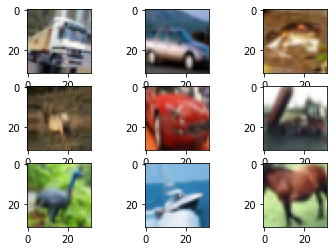

In [102]:
for X_batch, y_batch in datagen.flow(X_train[:9], y_train[:9], batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype('uint8'), cmap=plt.get_cmap('prism'))
    plt.show()
    break

In [103]:
#fitting image data generator on train data
datagen.fit(X_train)

batchx, batchy = datagen.flow(X_train[:1000], y_train[:1000], batch_size=1000).next()
print('Batch shape = %s, min = %.3f max=%.3f'%(batchx.shape, batchx.min(), batchx.max()))

Batch shape = (1000, 32, 32, 3), min = -1.989 max=2.127


In [104]:
#fitting image data generator on validation data
val_datagen.fit(X_test)

batchx, batchy = val_datagen.flow(X_test[:1000], y_test[:1000], batch_size=1000).next()
print('Batch shape = %s, min = %.3f max=%.3f'%(batchx.shape, batchx.min(), batchx.max()))

Batch shape = (1000, 32, 32, 3), min = -2.004 max=2.120


In [105]:
#custom callback to stop the model once validation accuracy reaches 90%
class Thr_Early_Stop(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(Thr_Early_Stop, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_accuracy = logs["val_accuracy"]
        if val_accuracy >= self.threshold:
            self.model.stop_training = True

In [106]:
def border_msg(msg):
    row = len(msg)
    h = ''.join(['+'] + ['-' *row] + ['+'])
    result= h + '\n'"|"+msg+"|"'\n' + h
    print(result)

In [107]:
def final_dense_net(X_train, X_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epoch = 15, nb_layers = 20, num_filter=12, dropout_rate=0.2):
  
  lr_reduce= ReduceLROnPlateau(monitor='val_accuracy', patience=8, verbose=1, factor=0.1, min_lr=0.0001)

  csv_logger = CSVLogger('training.log')

  filepath = 'gdrive/My Drive/Densenet_cifar/Models/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  def select_optim():
    if opt=='adam':
      return Adam(learning_rate=lr)
    elif opt=='sgd':
      return SGD(learning_rate=lr, momentum=0.7)
    elif opt=='adabound':
      return AdaBound(lr=lr)

  input = layers.Input(shape=(img_height, img_width, channel,))
  First_Conv2D = layers.Conv2D(num_filter, kernel, use_bias=False ,padding='same')(input)

  First_Block = denseblock(First_Conv2D, num_filter, dropout_rate, nb_layers)
  First_Transition = transition(First_Block, num_filter, dropout_rate)

  Second_Block = denseblock(First_Transition, num_filter, dropout_rate, nb_layers)
  Second_Transition = transition(Second_Block, num_filter, dropout_rate)

  Third_Block = denseblock(Second_Transition, num_filter, dropout_rate, nb_layers)
  Third_Transition = transition(Third_Block, num_filter, dropout_rate)

  Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate, nb_layers)
  output = output_layer(Last_Block)

  #early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=5)
  early_stop = Thr_Early_Stop(threshold=0.9)

  model = Model(inputs=[input], outputs=[output])
         
  model.compile(optimizer=select_optim(), loss='categorical_crossentropy', metrics=['accuracy'])

  print("-"*120)
  border_msg('MODEL SUMMARY')
  print("-"*120+'\n')
  print(model.summary())
  
  print("-"*120)
  border_msg('FITTING MODEL')
  print("-"*120+'\n')
  model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=len(y_train)//batch_size + 1,
                      epochs=epoch,verbose = 1,validation_data=val_datagen.flow(X_test, y_test, batch_size=batch_size),
                      validation_steps = len(y_test)//batch_size + 1, callbacks=[checkpoint, lr_reduce, early_stop])

  print("-"*120)
  border_msg('EVALUATING MODEL')
  print("-"*120+'\n')

  score = model.evaluate_generator(val_datagen.flow(X_test, y_test, batch_size=batch_size), verbose=1)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  return model

In [111]:
Train_model = final_dense_net(X_train, X_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epoch = 200, nb_layers = 12, num_filter=38, dropout_rate=0.2)

------------------------------------------------------------------------------------------------------------------------
+-------------+
|MODEL SUMMARY|
+-------------+
------------------------------------------------------------------------------------------------------------------------

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_728 (Conv2D)             (None, 32, 32, 38)   1026        input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_728 (BatchN (None, 32, 32, 38)   152         conv2d_728[0][0]                

In [144]:
train_acc = Train_model.evaluate(datagen.flow(X_train, y_train, batch_size=128), verbose=1)
val_acc   = Train_model.evaluate(val_datagen.flow(X_test, y_test, batch_size=128), verbose=1)

79/79 [==============================] - 5s 69ms/step - loss: 0.3219 - accuracy: 0.9064


In [160]:
print('The Train accuracy is     : {:.2f}%'.format(train_acc[1]*100))
print('The Test accuracy is      : {:.2f}%'.format(val_acc[1]*100))
print('Number of parameters used : {}'.format(Train_model.count_params()))

The Train accuracy is     : 92.57%
The Test accuracy is      : 90.64%
Number of parameters used : 4187192
